In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch and Lightning
import lightning as pl
from torch.utils.data import DataLoader, Subset

# Utilities
import logging
from tqdm import tqdm

# Calvera bandit library
from calvera.bandits import DiagonalPrecApproxLinearTSBandit
from calvera.benchmark.datasets import StatlogDataset
from calvera.benchmark import BanditBenchmarkEnvironment
from calvera.utils import ArgMaxSelector

In [2]:
# Load the Statlog dataset
dataset = StatlogDataset()

# Print dataset information
print(f"Context dimension size: {dataset.context_size}")
print(f"Total number of samples: {len(dataset)}")

Context dimension size: 49
Total number of samples: 58000


In [3]:
# Configuration
NUM_SAMPLES = 10000
BATCH_SIZE = 32
ACCELERATOR = "cpu"

# Create data loader with a subset of the dataset
train_loader = DataLoader(Subset(dataset, range(NUM_SAMPLES)), batch_size=BATCH_SIZE, shuffle=True)

# Initialize the bandit environment
env = BanditBenchmarkEnvironment(train_loader, device=ACCELERATOR)

# Initialize the LinearTSBandit model
bandit_module = DiagonalPrecApproxLinearTSBandit(
    n_features=dataset.context_size,
    selector=ArgMaxSelector(),
    lazy_uncertainty_update=True,
    eps=1e-2,
    lambda_=1e3,
).to(ACCELERATOR)

# Configure logging
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.FATAL)

In [4]:
# Initialize arrays to store metrics
rewards = np.array([])
regrets = np.array([])

# Training loop with progress bar
progress = tqdm(iter(env), total=len(env), desc="Training Linear bandit")
for contextualized_actions in progress:
    # Select actions based on current model
    contextualized_actions = contextualized_actions / 255.0
    chosen_actions, _ = bandit_module.forward(contextualized_actions)

    # Set up trainer for this step
    trainer = pl.Trainer(
        max_epochs=1,
        enable_progress_bar=False,
        enable_model_summary=False,
        accelerator=ACCELERATOR,
    )

    # Get feedback and compute regret
    chosen_contextualized_actions, realized_rewards = env.get_feedback(chosen_actions)
    batch_regret = env.compute_regret(chosen_actions)

    # Record metrics
    rewards = np.append(rewards, realized_rewards.cpu().numpy())
    regrets = np.append(regrets, batch_regret.cpu().numpy())

    # Update progress bar with current metrics
    progress.set_postfix(
        {
            "reward": realized_rewards.mean().item(),
            "regret": batch_regret.mean().item(),  # Fixed: was using reward value
            "avg_regret": regrets.mean(),
        }
    )

    # Update the bandit with feedback
    bandit_module.record_feedback(chosen_contextualized_actions, realized_rewards)
    trainer.fit(bandit_module)

    # Move the model back to the desired device
    # Required due to Lightning issue: https://github.com/Lightning-AI/pytorch-lightning/issues/10294
    bandit_module = bandit_module.to(ACCELERATOR)

# Create DataFrame with collected metrics
metrics = pd.DataFrame(
    {
        "reward": rewards,
        "regret": regrets,
    }
)

# Display the first few rows of metrics
metrics.head()

Training Linear bandit:   0%|          | 0/313 [00:00<?, ?it/s]/Users/robert/miniconda3/envs/neural_bandits/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/robert/miniconda3/envs/neural_bandits/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Training Linear bandit:   0%|          | 0/313 [00:00<?, ?it/s, reward=0.188, regret=0.812, avg_regret=0.812]/Users/robert/miniconda3/envs/neural_bandits/lib/python3.10/site-packages/

,reward,regret
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0


In [5]:
bandit_module.precision_matrix

tensor([[0.0100, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0147, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0100,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.9703, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.9703, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.9701]])

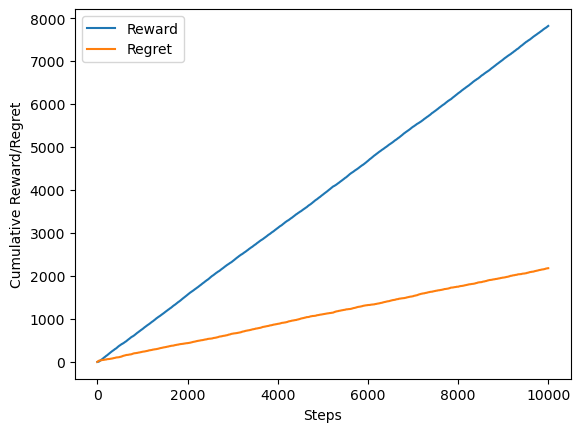

In [6]:
# Calculate cumulative metrics
cumulative_reward = np.cumsum(metrics["reward"])
cumulative_regret = np.cumsum(metrics["regret"])

# Plot cumulative regret and reward
plt.plot(cumulative_reward, label="Reward")
plt.plot(cumulative_regret, label="Regret")
plt.xlabel("Steps")
plt.ylabel("Cumulative Reward/Regret")
plt.legend()
plt.show()

In [7]:
# Calculate metrics for each time horizon
print(f"Average reward (first 10 rounds): {np.mean(metrics['reward'][:10]):.4f}")
print(f"Average reward (first 100 rounds): {np.mean(metrics['reward'][:100]):.4f}")
print(f"Average reward (all rounds): {np.mean(metrics['reward']):.4f}")
print("")
print(f"Average regret (first 10 rounds): {np.mean(metrics['regret'][:10]):.4f}")
print(f"Average regret (first 100 rounds): {np.mean(metrics['regret'][:100]):.4f}")
print(f"Average regret (all rounds): {np.mean(metrics['regret']):.4f}")

Average reward (first 10 rounds): 0.3000
Average reward (first 100 rounds): 0.5800
Average reward (all rounds): 0.7819

Average regret (first 10 rounds): 0.7000
Average regret (first 100 rounds): 0.4200
Average regret (all rounds): 0.2181
